# Appendix L: Compensated patch-clamp models

In [Appendix F](./appendix-E-non-ideal-op-amp.ipynb) we compared uncompensated patch-clamp models, omitting voltage offset and leak current for simplicity.
In this appendix, we compare models of _compensated_ patch clamp, again omitting offset and leak.

The schematic is shown below:

<img src="resources/patch-comp-7-no-leak-eoff.png" style="margin:auto" />

As with the uncompensated model, we can write the Sigworth and Lei-style models using very similar equations:

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p - V_m}{R_s} - I
\end{align}

\begin{align}
2a. && (C_p+C_f)\dot{V}_p &= \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref} \\
2b. && C_f\dot{V}_o &= \frac{V_p-V_o}{R_f} + \frac{V_p-V_m}{R_s} + \left(C_p+C_f\right)\dot{V}_p - C_m^* \dot{V}_\text{est} - C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
3a. && \tau_a \dot{V}_o &= V_\text{ref} - V_p \\
3b. && \tau_c\dot{V}_p &= V_\text{ref} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
6a. && R_f I_\text{obs} &= V_o - V_\text{ref} \\
6b. && R_f I_\text{obs} &= V_o - V_p
\end{align}

Where the Sigworth-style model consists of **(1, 2a, 3a, 4, 5, 6a)**, while the Lei model can be written as **(1, 2b, 3b, 4, 5, 6b)**.

## Simulations

We now run simulations for a single step from -80 to 20 mV.

In [1]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

## Sigworth-style model (1, 2a, 3a, 4, 5, 6a)

We start with a (1, 2a, 3a, 4, 5, 6a) model:

In [2]:
mA = myokit.parse_model('''
[[model]]
desc: Compensated model (1, 2a, 3a, 4, 5, 6a)
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 15e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 25 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm : Eq 1
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm * dot(Ve) + Cp * dot(Vr)
          ) / (Cp + Cf) : Eq 2a
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp : Eq 3a
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est) : Eq 4
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum : Eq 5
    in [mV]
I_obs = (Vo - Vr) / Rf : Eq 6a
    in [pA]
''')
mA.check_units(myokit.UNIT_STRICT)

In [3]:
vlo, vhi = -80, 20
p = myokit.Protocol()
p.add_step(level=vlo, duration=5)
p.add_step(level=vhi, duration=15)

In [4]:
def axs(fig, sub=(1, 1, 1), xlabel='Time (ms)', ylabel=''):
    ax = fig.add_subplot(*sub)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

def ins(ax, loc=(0.05, 0.20, 0.40, 0.65)):
    ins = ax.inset_axes(loc)
    ins.set_yticklabels([])
    ins.set_xlim(t1, t2)
    ins.patch.set_alpha(0.5)    
    return ins

def plot(d, t1, t2, axes=None, label=None, ls=None):
    if axes is None:
        fig = plt.figure(figsize=(15, 12))
        
        ax1 = axs(fig, (3, 2, 1), 'Vm (mV)')
        ax2 = axs(fig, (3, 2, 2), 'Vp (mV)')
        ax3 = axs(fig, (3, 2, 3), 'Vest (mV)')
        ax4 = axs(fig, (3, 2, 4), 'Vo (mV)')
        ax5 = axs(fig, (3, 2, 5), 'Vref (mV)')
        ax6 = axs(fig, (3, 2, 6), 'Iobs (mV)')
        in1, in2 = ins(ax1), ins(ax2)
        in4, in5, in6 = ins(ax4), ins(ax5), ins(ax6)
        in1.set_xlim(5, 10)
        in1.set_ylim(10, 23)
        in5.set_ylim(-30, 60)
    else:
        [ax1, ax2, ax3, ax4, ax5, ax6, in1, in2, in4, in5, in6] = axes
        
    ax1.plot(d.time(), d['amp.Vm'], label=label, ls=ls)
    in1.plot(d.time(), d['amp.Vm'], label=label, ls=ls)
    ax2.plot(d.time(), d['amp.Vp'], ls=ls)
    in2.plot(d.time(), d['amp.Vp'], ls=ls)
    ax3.plot(d.time(), d['amp.Ve'], ls=ls)
    if 'amp.Vo' in d:
        ax4.plot(d.time(), d['amp.Vo'], ls=ls)
        in4.plot(d.time(), d['amp.Vo'], ls=ls)
    ax5.plot(d.time(), d['amp.Vr'], ls=ls)
    in5.plot(d.time(), d['amp.Vr'], ls=ls)
    ax6.plot(d.time(), d['amp.I_obs'], ls=ls)
    in6.plot(d.time(), d['amp.I_obs'], ls=ls)
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, in1, in2, in4, in5, in6]

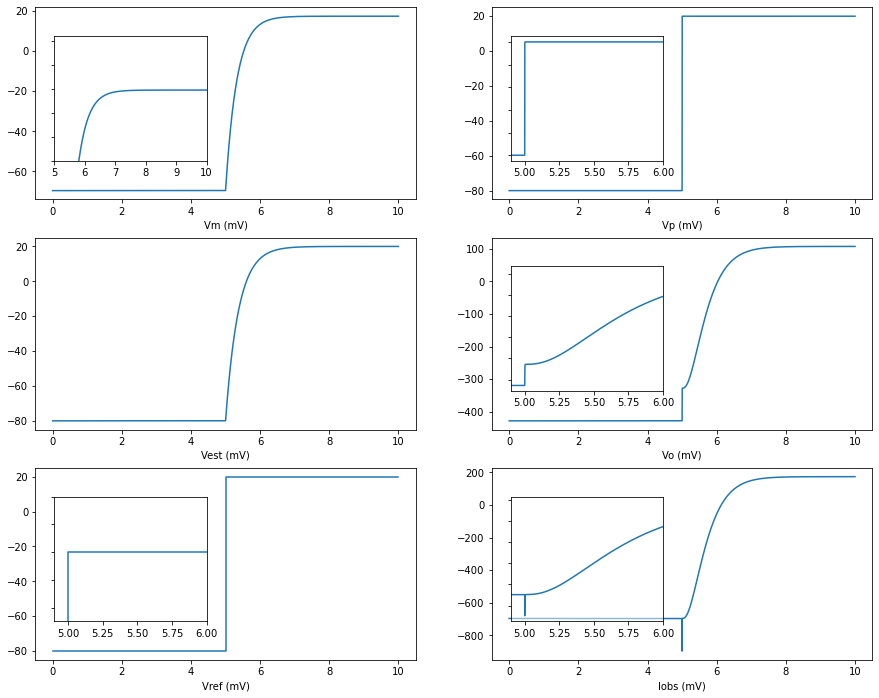

Final Vm: 17.391283869307433


In [5]:
tol = 1e-8
dt = 5e-5

t0 = 10
t1 = 4.9
t2 = 6

sA = myokit.Simulation(mA, p)
sA.set_tolerance(tol, tol)

sA.set_constant('amp.alpha', 0)        # No correction
sA.set_constant('amp.beta', 0)         # No prediction
sA.set_constant('amp.tau_sum', 1e-9)   # Very fast filtering of Vc

sA.pre(t1)
dA = sA.run(t0)
ax = plot(dA, t1, t2)
plt.show()

print(f'Final Vm: {dA["amp.Vm"][-1]}')

Now we gradually switch compensation on and run again

In [6]:
sA.reset()
sA.set_constant('amp.tau_sum', 10e-3)
sA.pre(t1)
dA1 = sA.run(t0)
print(f'Final Vm: {dA1["amp.Vm"][-1]}')

sA.reset()
sA.set_constant('amp.alpha', 0.4)
sA.pre(t1)
dA2 = sA.run(t0)
print(f'Final Vm: {dA2["amp.Vm"][-1]}')

sA.reset()
sA.set_constant('amp.alpha', 0.8)
sA.pre(t1)
dA3 = sA.run(t0)
print(f'Final Vm: {dA3["amp.Vm"][-1]}')

Final Vm: 17.391283292783555
Final Vm: 18.348481806247516
Final Vm: 19.417312486256662


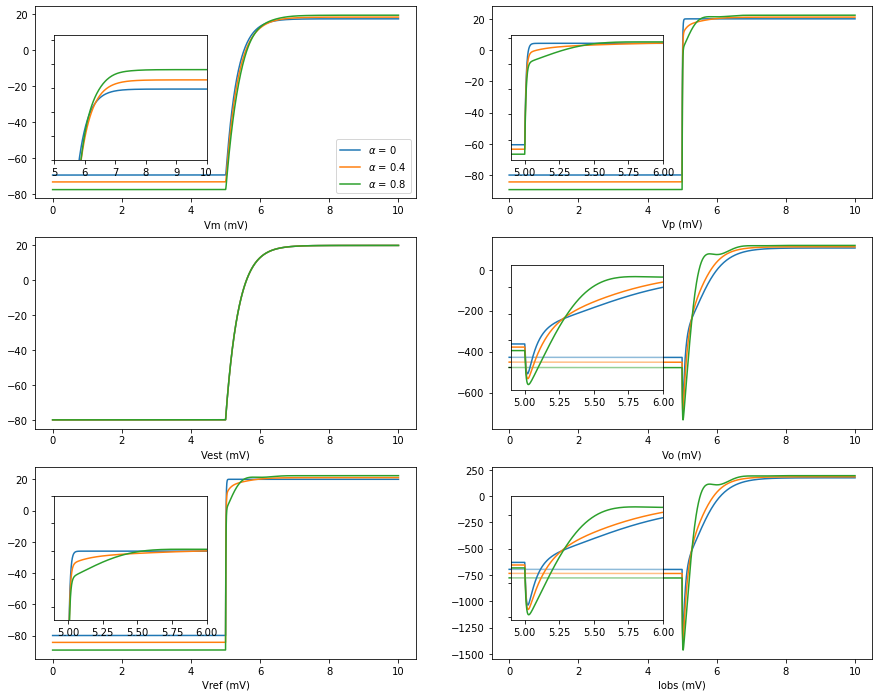

In [7]:
ax = plot(dA1, t1, t2, label='$\\alpha$ = 0')
ax = plot(dA2, t1, t2, axes=ax, label='$\\alpha$ = 0.4')
ax = plot(dA3, t1, t2, axes=ax, label='$\\alpha$ = 0.8')
ax[0].legend(loc='lower right')
plt.show()

In [8]:
sA.reset()
sA.set_constant('amp.alpha', 0)
sA.set_constant('amp.beta', 0)
sA.pre(t1)
dA1 = sA.run(t0)
print(f'Final Vm: {dA1["amp.Vm"][-1]}')

sA.reset()
sA.set_constant('amp.alpha', 0.4)
sA.set_constant('amp.beta', 0.4)
sA.pre(t1)
dA2 = sA.run(t0)
print(f'Final Vm: {dA2["amp.Vm"][-1]}')

sA.reset()
sA.set_constant('amp.alpha', 0.8)
sA.set_constant('amp.beta', 0.8)
sA.pre(t1)
dA3 = sA.run(t0)
print(f'Final Vm: {dA3["amp.Vm"][-1]}')

Final Vm: 17.3912832927908
Final Vm: 18.348623869204296
Final Vm: 19.41745677956826


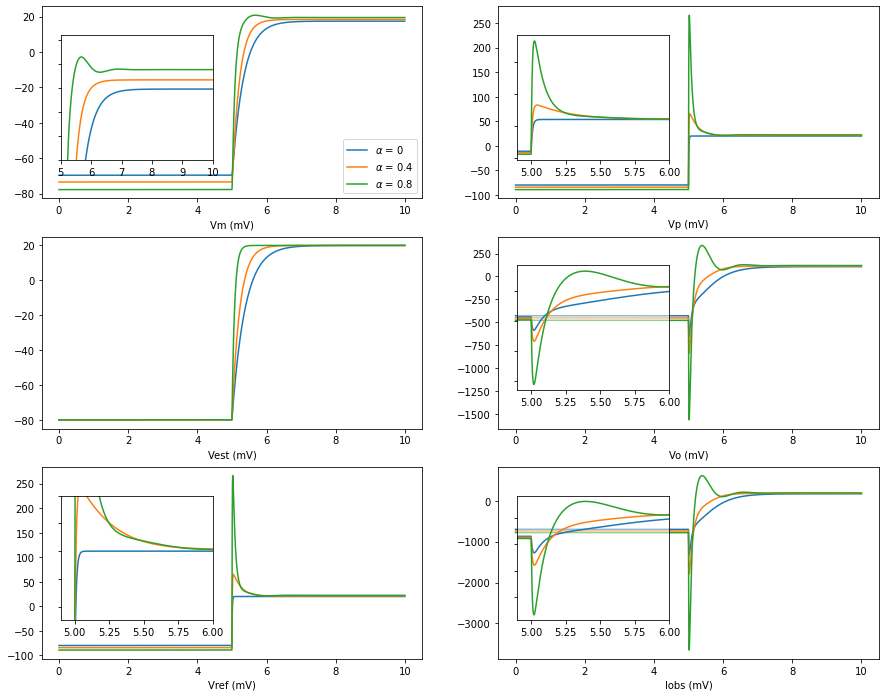

In [9]:
ax = plot(dA1, t1, t2, label='$\\alpha$ = 0')
ax = plot(dA2, t1, t2, axes=ax, label='$\\alpha$ = 0.4')
ax = plot(dA3, t1, t2, axes=ax, label='$\\alpha$ = 0.8')
ax[0].legend(loc='lower right')
plt.show()

## Lei-style model (1, 2b, 3b, 4, 5, 6b)

As with the uncompensated model, we can write the Sigworth and Lei-style models using very similar equations:

\begin{align}
2b. && C_f\dot{V}_o = \frac{V_p-V_o}{R_f} + \frac{V_p-V_m}{R_s} + \left(C_p+C_f\right)\dot{V}_p - C_m^* \dot{V}_\text{est} - C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
3b. && \tau_c\dot{V}_p = V_\text{ref} - V_p
\end{align}

\begin{align}
6b. && R_f I_\text{obs} = V_o - V_p
\end{align}

In [10]:
mB = myokit.parse_model('''
[[model]]
desc: Compensated model (1, 2b, 3b, 4, 5, 6b)
amp.Vm = -80
amp.Vo = -80
amp.Vp = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 15e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 25 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm : Eq 1
    in [mV]
dot(Vo) = ((Vp - Vo) / Rf + (Vp - Vm) / Rs +
           (Cp + Cf) * dot(Vp) - Cm_est * dot(Ve) - Cp_est * dot(Vr)
          ) / Cf : Eq 2b
    in [mV]
dot(Vp) = (Vr - Vp) / tau_c : Eq 3b
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est) : Eq 4
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum : Eq 5
    in [mV]
I_obs = (Vo - Vp) / Rf : Eq 6b
    in [pA]
''')
mB.check_units(myokit.UNIT_STRICT)

In [11]:
sB = myokit.Simulation(mB, p)
sB.set_tolerance(tol, tol)

sB.reset()
sB.set_constant('amp.alpha', 0)
sB.set_constant('amp.beta', 0)
sB.pre(t1)
dB1 = sB.run(t0)
print(f'Final Vm: {dB1["amp.Vm"][-1]}')

sB.reset()
sB.set_constant('amp.alpha', 0.4)
sB.set_constant('amp.beta', 0.4)
sB.pre(t1)
dB2 = sB.run(t0)
print(f'Final Vm: {dB2["amp.Vm"][-1]}')

sB.reset()
sB.set_constant('amp.alpha', 0.8)
sB.set_constant('amp.beta', 0.8)
sB.pre(t1)
dB3 = sB.run(t0)
print(f'Final Vm: {dB3["amp.Vm"][-1]}')

Final Vm: 17.391284629011796
Final Vm: 18.348623814025718
Final Vm: 19.41745563458149


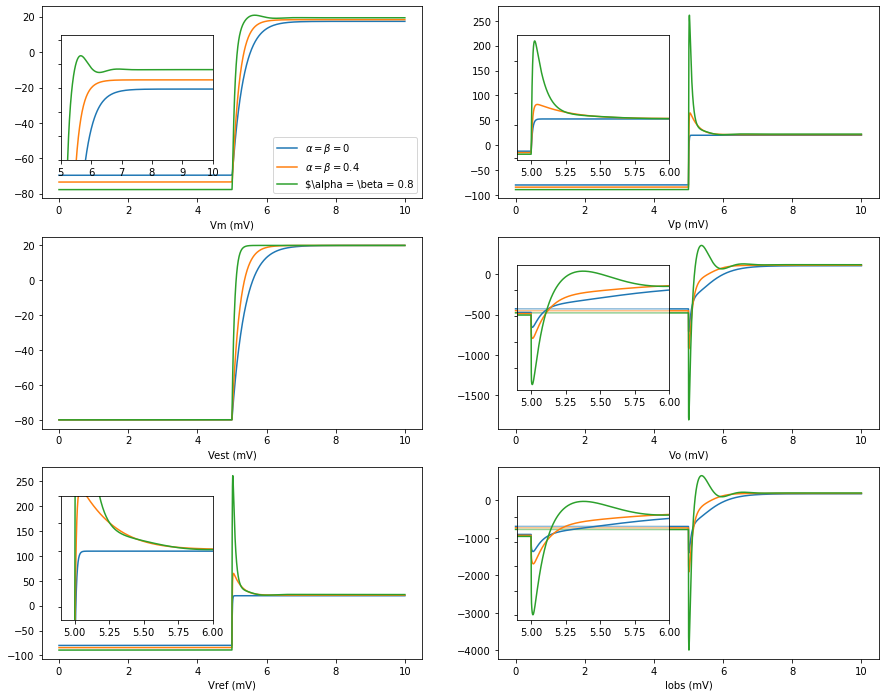

In [12]:
ax = plot(dB1, t1, t2, label='$\\alpha = \\beta = 0$')
ax = plot(dB2, t1, t2, axes=ax, label='$\\alpha = \\beta = 0.4$')
ax = plot(dB3, t1, t2, axes=ax, label='$\\alpha = \\beta = 0.8')
ax[0].legend(loc='lower right')
plt.show()

To be safe, we also test with the Lei model in its original formulation:

In [13]:
mC = myokit.parse_model('''
[[model]]
desc: Lei formulation. Should equal (1, 2b, 3b, 4, 5, 6b)
amp.Vm = -80
amp.Vp = -80
amp.Ve = -80
amp.Vr = -80
amp.I_obs = 0

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 15e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 25 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = (Vr - Vp) / tau_c
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_in = I + Cp * dot(Vp) + Cm * dot(Vm) - Cp_est * dot(Vr) - Cm_est * dot(Ve)
    in [pA]
dot(I_obs) = (I_in - I_obs) / (Rf * Cf)
    in [pA]
''')
mC.check_units(myokit.UNIT_STRICT)
sC = myokit.Simulation(mC, p)

## Model predictions overlayed

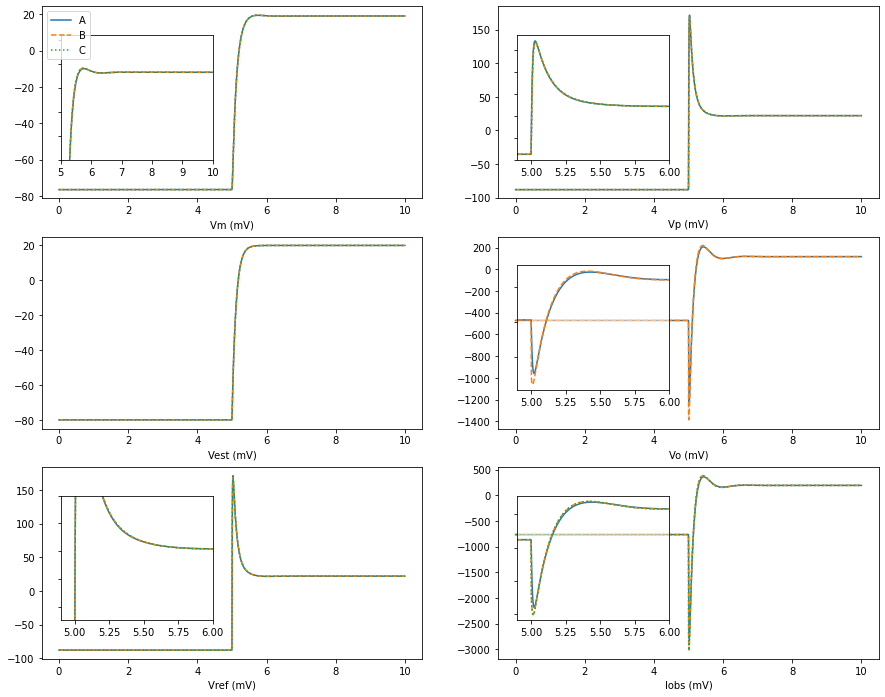

In [14]:
for s in (sA, sB, sC):
    s.reset()
    s.set_constant('amp.alpha', 0.7)
    s.set_constant('amp.beta', 0.7)
    s.set_tolerance(1e-10, 1e-10)
    s.pre(t1)

dt = 1e-3
dA = sA.run(t0, log_interval=dt).npview()
dB = sB.run(t0, log_interval=dt).npview()
dC = sC.run(t0, log_interval=dt).npview()

tz = 0.05
ax = plot(dA, t1, t2, label='A')
ax = plot(dB, t1, t2, ax, label='B', ls='--')
ax = plot(dC, t1, t2, ax, label='C', ls=':')
ax[0].legend()
plt.show()

Most traces look the same, but $I_\text{obs}$ differs a bit between A and models B and C.

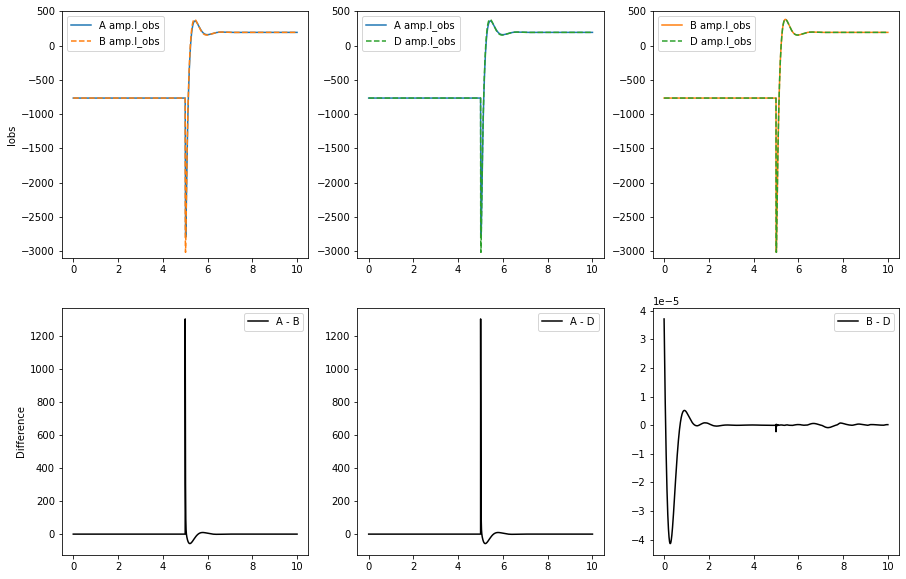

In [15]:
t = dA.time()
logs = (dA, dB, dC)
names = ('A', 'B', 'D')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
v = 'amp.I_obs'

fig = plt.figure(figsize=(15, 10))
for (i, j, k) in ((0, 0, 1), (1, 0, 2), (2, 1, 2)):
    ax1 = fig.add_subplot(2, 3, 1 + i)
    ax1.plot(t, logs[j][v], color=colors[j], label=f'{names[j]} {v}')
    ax1.plot(t, logs[k][v], color=colors[k], label=f'{names[k]} {v}', ls='--')
    ax1.set_ylim(-3100, 500)
    ax2 = fig.add_subplot(2, 3, 4 + i)
    ax2.plot(t, logs[j][v] - logs[k][v], color='k', label=f'{names[j]} - {names[k]}')
    ax1.legend()
    ax2.legend()
    if i == 0:
        ax1.set_ylabel('Iobs')
        ax2.set_ylabel('Difference')

plt.show()

We see that the models show very similar output, but a difference between A and B can be detected when the two signals are subtracted.
As before, the reformulation of B doesn't affect the results.